In [31]:
#https://www.kaggle.com/ekhtiar/finding-pneumo-part-1-eda-and-unet

In [18]:
import pydicom
import pandas as pd
import numpy as np
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import os
from glob import glob

In [10]:
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)



In [23]:
rles_df = pd.read_csv('siim/train-rle.csv')
rles_df.columns = ['ImageId', 'EncodedPixels']

In [24]:
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [25]:
df.iloc[2]["ImageId"]

'1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709'

In [26]:
def dicom_to_dict(dicom_data, file_path, rles_df, encoded_pixels=True):
    """Parse DICOM dataset and returns a dictonary with relevant fields.

    Args:
        dicom_data (dicom): chest x-ray data in dicom format.
        file_path (str): file path of the dicom data.
        rles_df (pandas.core.frame.DataFrame): Pandas dataframe of the RLE.
        encoded_pixels (bool): if True we will search for annotation.
        
    Returns:
        dict: contains metadata of relevant fields.
    """
    
    data = {}
    
    # Parse fields with meaningful information
    data['patient_name'] = dicom_data.PatientName
    data['patient_id'] = dicom_data.PatientID
    data['patient_age'] = int(dicom_data.PatientAge)
    data['patient_sex'] = dicom_data.PatientSex
    data['pixel_spacing'] = dicom_data.PixelSpacing
    data['file_path'] = file_path
    data['id'] = dicom_data.SOPInstanceUID
    
    # look for annotation if enabled (train set)
    if encoded_pixels:
        encoded_pixels_list = rles_df[rles_df['ImageId']==dicom_data.SOPInstanceUID]['EncodedPixels'].values
       
        pneumothorax = False
        for encoded_pixels in encoded_pixels_list:
            if encoded_pixels != ' -1':
                pneumothorax = True
        
        # get meaningful information (for train set)
        data['encoded_pixels_list'] = encoded_pixels_list
        data['has_pneumothorax'] = pneumothorax
        data['encoded_pixels_count'] = len(encoded_pixels_list)
        
    return data

In [27]:
# create a list of all the files
train_fns = sorted(glob('siim/dicom-images-train/*/*/*.dcm'))
# parse train DICOM dataset
train_metadata_df = pd.DataFrame()
train_metadata_list = []
for file_path in train_fns:
    dicom_data = pydicom.dcmread(file_path)
    train_metadata = dicom_to_dict(dicom_data, file_path, rles_df)
    train_metadata_list.append(train_metadata)
train_metadata_df = pd.DataFrame(train_metadata_list)

In [28]:
# create a list of all the files
test_fns = sorted(glob('siim/dicom-images-test/*/*/*.dcm'))
# parse test DICOM dataset
test_metadata_df = pd.DataFrame()
test_metadata_list = []
for file_path in test_fns:
    dicom_data = pydicom.dcmread(file_path)
    test_metadata = dicom_to_dict(dicom_data, file_path, rles_df, encoded_pixels=False)
    test_metadata_list.append(test_metadata)
test_metadata_df = pd.DataFrame(test_metadata_list)

In [30]:
train_metadata_df.iloc[0]['file_path']

'siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.1000.1517875165.878026/1.2.276.0.7230010.3.1.3.8323329.1000.1517875165.878025/1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.dcm'

In [35]:
train_metadata_df.iloc[0]

encoded_pixels_count                                                    1
encoded_pixels_list                                                 [ -1]
file_path               siim/dicom-images-train/1.2.276.0.7230010.3.1....
has_pneumothorax                                                    False
id                      1.2.276.0.7230010.3.1.4.8323329.1000.151787516...
patient_age                                                            38
patient_id                           17d405a3-a0d2-4901-b33a-63906aa48d9f
patient_name                         17d405a3-a0d2-4901-b33a-63906aa48d9f
patient_sex                                                             M
pixel_spacing                                              [0.168, 0.168]
Name: 0, dtype: object

In [32]:
dat = pydicom.dcmread(train_metadata_df.iloc[0]['file_path'])

In [33]:
show_dcm_info(dat)

Filename.........: siim/dicom-images-test/1.2.276.0.7230010.3.1.2.8323329.7052.1517875202.524576/1.2.276.0.7230010.3.1.3.8323329.7052.1517875202.524575/1.2.276.0.7230010.3.1.4.8323329.7052.1517875202.524577.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: 17d405a3-a0d2-4901-b33a-63906aa48d9f, 
Patient id..........: 17d405a3-a0d2-4901-b33a-63906aa48d9f
Patient's Age.......: 38
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 130476 bytes
Pixel spacing....: ['0.168', '0.168']


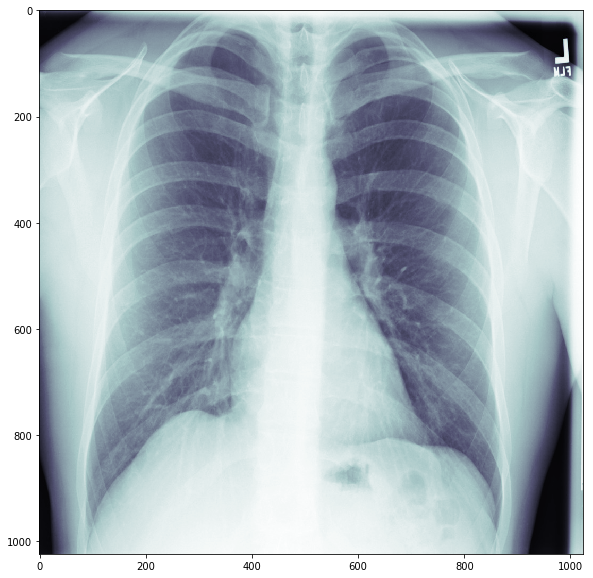

In [34]:
plot_pixel_array(dat)

In [36]:
train_metadata_df.iloc[0]['has_pneumothorax']

False

In [38]:
train_metadata_df.iloc[100]['has_pneumothorax']

True

In [98]:
train_metadata_df.head()

,encoded_pixels_count,encoded_pixels_list,file_path,has_pneumothorax,id,patient_age,patient_id,patient_name,patient_sex,pixel_spacing
0,1,[ -1],siim/dicom-images-train/1.2.276.0.7230010.3.1....,False,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,38,17d405a3-a0d2-4901-b33a-63906aa48d9f,17d405a3-a0d2-4901-b33a-63906aa48d9f,M,"[0.168, 0.168]"
1,1,[ -1],siim/dicom-images-train/1.2.276.0.7230010.3.1....,False,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,10,8ab1ffda-8b65-4914-95d6-2e549e328666,8ab1ffda-8b65-4914-95d6-2e549e328666,F,"[0.139, 0.139]"
2,1,[ -1],siim/dicom-images-train/1.2.276.0.7230010.3.1....,False,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,50,bfef51d3-6541-4792-bac1-d21d41ee60fd,bfef51d3-6541-4792-bac1-d21d41ee60fd,F,"[0.168, 0.168]"
3,1,[ -1],siim/dicom-images-train/1.2.276.0.7230010.3.1....,False,1.2.276.0.7230010.3.1.4.8323329.10002.15178752...,68,d19d956f-4ddd-4688-81ff-909c85e0e2d9,d19d956f-4ddd-4688-81ff-909c85e0e2d9,F,"[0.139, 0.139]"
4,1,[ -1],siim/dicom-images-train/1.2.276.0.7230010.3.1....,False,1.2.276.0.7230010.3.1.4.8323329.10003.15178752...,65,cf71a760-f693-4ccf-acd4-a41ff4845a5f,cf71a760-f693-4ccf-acd4-a41ff4845a5f,M,"[0.168, 0.168]"


In [39]:
dat = pydicom.dcmread(train_metadata_df.iloc[100]['file_path'])

In [76]:
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    
    array = np.asarray([int(x) for x in rle.split()])
#     print(array.shape)
    starts = array[0::2]
#     print(starts)
    lengths = array[1::2]
#     print(lengths)

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [77]:
def plot_pixel_array(data, figsize=(10,10)):
    dat = pydicom.dcmread(data['file_path'])
    plt.figure()
    plt.subplots(figsize=figsize)
    plt.imshow(dat.pixel_array, cmap=plt.cm.bone)
    if data['has_pneumothorax']:
#         mask = rle2mask(data['encoded_pixels_list'], 1024,1024)
#         plt.imshow(mask, alpha=.4)
        mask_decoded_list = [rle2mask(mask_encoded, 1024, 1024).T for mask_encoded in data['encoded_pixels_list']]
#         print('mask', mask_decoded_list.shape)
        for mask_decode in mask_decoded_list:
            plt.imshow(mask_decode, alpha=.4)
    plt.show()


<Figure size 432x288 with 0 Axes>

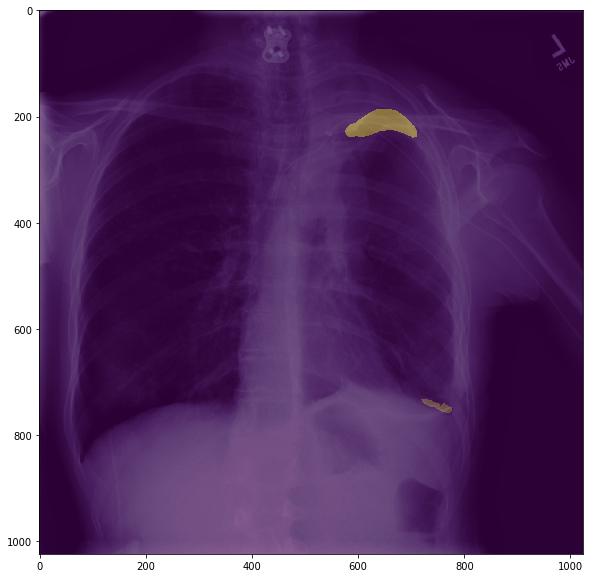

In [78]:
plot_pixel_array(train_metadata_df.iloc[100])

In [49]:
train_metadata_df.iloc[100]['encoded_pixels_list']

array([' 736990 1 1022 2 1022 5 1019 5 1019 6 1018 7 1017 8 1016 8 1016 9 1015 9 1015 10 1014 11 1013 11 1013 12 1013 11 1013 12 1012 12 1012 13 1011 13 1012 12 1012 13 1012 12 1012 12 1013 11 1013 11 1014 10 1014 11 1013 12 1012 13 1012 12 1013 11 1013 12 1012 12 1012 13 1012 12 1014 10 1016 9 1015 10 1013 11 1013 12 1010 14 1008 17 1006 18 1007 17 1007 17 1007 17 1008 17 1008 16 1009 15 1010 14 1010 14 1011 13 1012 12 1013 11 1013 10 1014 10 1014 9 1016 7 1018 5',
       ' 590050 5 1017 11 1012 13 1009 16 1007 18 1005 19 1004 21 1002 22 1001 23 1001 23 1000 24 999 25 999 25 999 25 999 25 999 25 998 26 998 26 998 26 997 26 997 27 997 27 996 28 995 29 994 31 993 31 992 32 991 34 990 34 989 35 988 36 987 37 986 38 985 39 985 39 984 39 984 40 984 39 984 40 983 41 983 40 983 41 982 42 982 42 981 43 981 42 981 43 981 43 980 43 981 43 980 43 981 43 980 43 981 43 980 43 981 43 980 44 980 44 980 43 980 44 980 43 981 43 981 42 981 43 981 42 982 42 982 42 982 42 982 42 982 42 982 41 983 41 983 

In [82]:
mk = [rle2mask(mask_encoded, 1024, 1024).T for mask_encoded in train_metadata_df.iloc[100]['encoded_pixels_list']]

In [83]:
mk

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]

In [89]:
len(mk)

2

In [91]:
mk[0].shape

(1024, 1024)

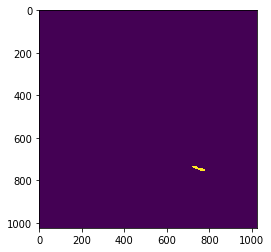

In [92]:
plt.imshow(mk[0])

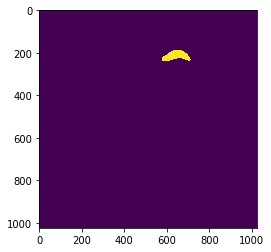

In [93]:
plt.imshow(mk[1])

In [94]:
np.unique(mk[1])

array([  0., 255.])

In [95]:
np.count_nonzero(mk[1])

4606

In [96]:
np.count_nonzero(mk[0])

659

In [100]:
train_metadata_df.has_pneumothorax.value_counts()

False    8296
True     2379
Name: has_pneumothorax, dtype: int64

In [101]:
len(train_metadata_df)

10675